**2. Model validation playbook and automation** - we also have the BAML model validation playbook. This includes all of the necessary tests and expectations from model developers for an OLS model. We want to create a script to code these up. We will need to brief prior to starting. 
- BAML Linear Regression Validation Playbook
- Many of the tests require the residual
- Diagnostics Tests (95% confidence level)
 - Linearity 	
 - Heteroscedasticity (statistically)	
 - Independence (serial correlation)	
 - Normality (statistically and visually using histogram or Q-Q Plot)
 - Multicollinearity (correlation, tolerance, VIF)
 - Goodness of Fit
    + R2, Adj_R2, RMSE, F-test
    + T-test, p-value
    + Forward selection method (variable selection)
- Performance Tests
 - Out-of-Sample Testing	
 - Cross Validation	
 - Sensitivity Testing


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy import stats
import datarobot as dr
from tabulate import tabulate
import os
import stress_test
import utils_ui, utils_stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')
PROJECT_ID = '5ae80239b391712c74b552ed'
MODEL_ID = '5ae802a83c3b8be79edd6cec'

project = dr.Project.get(project_id=PROJECT_ID)
print('project.project_name:',project.project_name)
print('project.file_name:',project.file_name)
print('project.metric:',project.metric)
print('project.target:',project.target)
model = dr.Model.get(project=PROJECT_ID, model_id=MODEL_ID)
print('model.model_type:',model.model_type)

project.project_name: Model val home sales
project.file_name: train_housing_kaggle.csv
project.metric: Gamma Deviance
project.target: SalePrice
model.model_type: eXtreme Gradient Boosted Trees Regressor (Poisson Loss)


In [3]:
data_path = 'data/train_housing_kaggle.csv'
{'train_housing_kaggle', 'DR_Demo_Fire_Ins_Loss_only', '10K_Lending_Club_Loans'}
df = pd.read_csv(data_path, encoding = "ISO-8859-1", parse_dates=['SaleDate'])

In [4]:
# Get the cross validation folds from the original project run
data_cvfs = stress_test.get_cv_folds(PROJECT_ID, MODEL_ID)
print(data_cvfs.cv_fold.value_counts())

data_cvfs[project.target] = df[project.target]
data_cvfs.head()

Training predictions are already requested and are ready.
- Time: 'get_cv_folds' 5.23
Holdout    292
1.0        234
2.0        234
0.0        234
4.0        233
3.0        233
Name: cv_fold, dtype: int64


,cv_fold,prediction,SalePrice
row_id,,,
0,Holdout,210570.546875,208500
1,1.0,169455.265625,181500
2,0.0,217963.687500,223500
3,4.0,171729.140625,140000
4,Holdout,312308.187500,250000


In [5]:
# Get the top n features for the model
top_features = stress_test.get_top_n_features(PROJECT_ID, MODEL_ID, 10)
print()
print('top_features:\n', top_features, '\n')
feature_set = top_features

# Get the columns with numeric data types
g = df[top_features].columns.to_series().groupby(df.dtypes).groups
g = df.columns.to_series().groupby(df.dtypes).groups
cols_list = [v.values for k, v in g.items() if str(k) != "object"]
numeric_cols = np.concatenate(cols_list).ravel()
# print(numeric_cols)
# feature_set = numeric_cols

# Identify categorical numeric vs continuous numeric columns
likely_cat = []
likely_cont = []
cols = feature_set  # .tolist()
for col in cols:
    if utils_ui.is_likely_categorical(df, col):
        likely_cat.append(col)
    else:
        likely_cont.append(col)
print('likely categorical:\n',likely_cat)
print()
print('likely continuous:\n',likely_cont)

Model type: eXtreme Gradient Boosted Trees Regressor (Poisson Loss)
Requesting feture impact for model 5ae802a83c3b8be79edd6cec
Feature impact compute done.
- Time: 'get_top_n_features' 3.61

top_features:
 ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'OverallCond', 'BsmtFinSF1', 'LotArea', 'YearRemodAdd', 'GarageCars', '1stFlrSF'] 

likely categorical:
 ['OverallQual', 'OverallCond', 'YearRemodAdd', 'GarageCars']

likely continuous:
 ['GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'LotArea', '1stFlrSF']


# 1. Goodness of Fit - OLS Regression results

Test Name | Description | Key Considerations
--- | --- | ---
R2 | Measures the proportion of the variation in the dependent variable, which is explained by the independent variables. Ranges between 0 and 1. | While R2 provides an indication of the strength of the relationship between the dependent and independent variables, it does not provide a formal hypothesis test for such a relationship. Therefore, a high R2 does not necessarily imply that useful predictions can be made using the regression function. Conversely, a low R2 does not imply that a regression function is not useful but only that it does not explain all of the variation. Given these limitations, R2 is more useful when used as a relative measure to compare similar models rather than an absolute measure of regression fit. Also, R2 is sensitive to the number of independent variables included in the regression equation. The addition of more independent variables can never lower R2 and is likely to raise it regardless of their explanatory power. Adjusted R2 addresses this issue (see below). Generally, an R2 of less than 10% would be a cause of particular concern and should therefore be evaluated carefully taking into account the model context and other test results.
Adjusted R2 | Adjusts R2 by taking into account the degrees of freedom / number of independent variables. | Corrects for the sensitivity to the number of independent variables described above.
Root Mean Square Error | Standard deviation of the error term, which corresponds to the square root of the mean square error (RMSE). A measure of the average difference between the predicted and actual values. | Has the same unit of measurement as the quantity that is being estimated by the regression function and can therefore be directly linked to business usefulness. It is useful for comparing different regression specifications over the same data sample or the same specification across different data samples (e.g., out of sample testing).
F-Test | Tests the null hypothesis that none of the independent variables explain the variation of the dependent variable. | Higher F values would suggest rejection of the null hypothesis and, therefore, are an indication of a good fit. Critical values are determined based on the F distribution and selected confidence level.
T-Test | Individually tests the significance of each independent variable through the null hypothesis so that the respective coefficients are equal to zero. | Higher t-values would suggest rejection of the null hypotheses and, therefore, are an indication that the variable is appropriately included. Critical values are determined based on the t distribution and selected confidence level. A high f-value with low t-values could suggest the existence of highly correlated independent variables or multicollinearity. 
P-values | Used for null hypothesis testing in association with the F-tests and Ttests. The p values correspond to the probability of getting data that generate parameter estimates, which are equal or greater than the estimated ones given that the null hypothesis is true. | Smaller p-values suggest a rejection of the null hypothesis and higher p-values suggest that the data is consistent with the null hypothesis (i.e., that the model may not add predictive value). P-values can be compared to selected significance levels to determine whether to accept or reject the null hypothesis (e.g., a p-value below the chosen significance level would lead to the rejection of the null hypothesis).


### The statsmodels summary values:

In [6]:
X = df[top_features]
y = df[project.target]
X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     546.0
Date:                Thu, 10 May 2018   Prob (F-statistic):               0.00
Time:                        10:58:14   Log-Likelihood:                -17404.
No. Observations:                1460   AIC:                         3.483e+04
Df Residuals:                    1449   BIC:                         3.489e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.121e+06   1.17e+05     -9.538   

# 2. Linearity

Test Name | Description | Key Considerations
--- | --- | ---
Dependent vs. Independent Variable Plot | Plot independent variable on X-axis, Plot dependent variable on Y-axis. | These plots are useful in identifying nonlinear relationships between the dependent and independent variables. Nonlinearity can often, but not always, present itself as a nonlinear pattern in the plots. When dealing with very large data sets, scatter plots may become cluttered and not easy to interpret. Visualization techniques, such as sampling, binning, or moving averages, can be employed to address this issue. For categorical independent variables generate a box plot (or bar chart) to illustrate the dependent variable’s distribution on each category. A predictive categorical variable is expected to have substantially heterogeneous means across categories.
Residual Plot | Plot independent variable on X-axis, Plot residual on Y-axis. | These plots are useful in identifying nonlinear relationships at an individual variable level based on the residual of the corresponding simple regression. For categorical independent variables generate a box plot to illustrate the residual distribution on each category. Residuals are expected to show close to zero means and constant variance across categories.

###  Visual inspection of data to determine if any transformation is necessary, e.g. log transform
Scatter plots for continuous data, box plots for categorical data to express dependent vs independent variables.  See #3 Heteroskedasticity below for the residual plots.


Univariate Scatter Plots for Continuous Independent Variables:


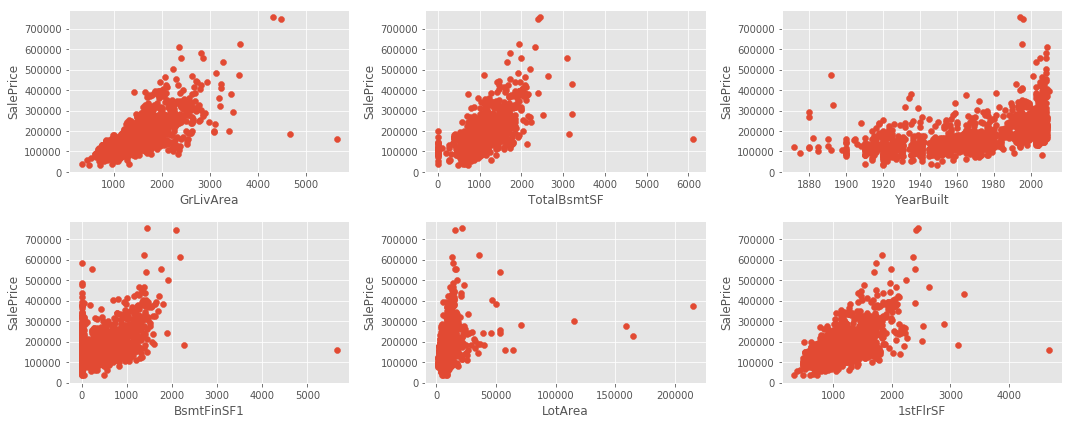

In [7]:
print('Univariate Scatter Plots for Continuous Independent Variables:')
fig, axs = utils_ui.dynamic_subplots(df, likely_cont, project.target, 'scatter', figsize=(15,6))
fig.tight_layout()
plt.show()

Box Plots for Categorical Independent Variables:


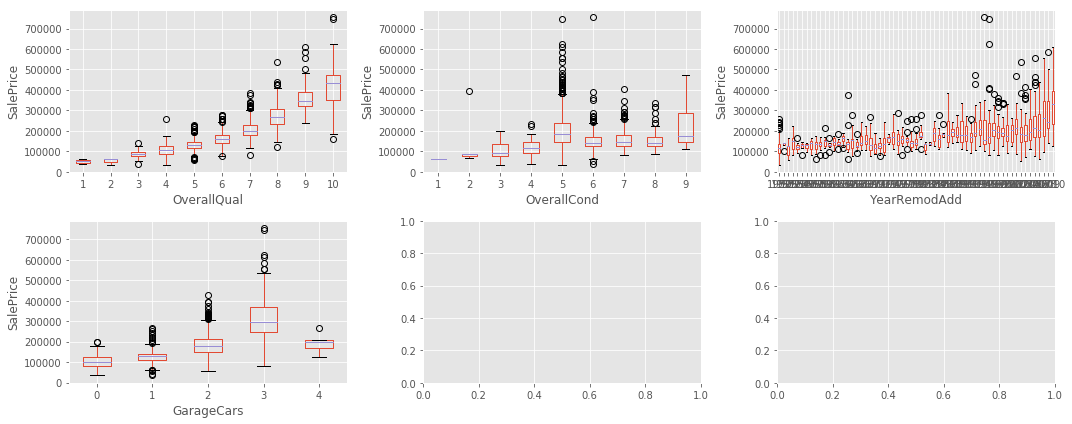

In [8]:
print('Box Plots for Categorical Independent Variables:')
fig, axs = utils_ui.dynamic_subplots(df, likely_cat, project.target, 'box', figsize=(15,6))
fig.tight_layout()
plt.show()

## -- 2. Linearity statistical tests --

Test Name | Description | Key Considerations
--- | --- | ---
Ramsey RESET Test | Tests the null hypothesis that the relationships in the regression are linear. Perform an auxiliary regression of the dependent variable against all the independent variables and higher order powers of the predicted value. Subsequently, perform an F-test on the auxiliary regression. | If the F-test exceeds a threshold value, the null hypothesis can be rejected (i.e., one or more nonlinear terms are significant). Often including only the second power of the predicted value will suffice to capture nonlinearity as this implicitly covers second order terms and interactions of the original independent variables. This test is not applicable where the regression includes categorical independent variables.
Chow Test | Test the null hypothesis that there is no structural break in the data using the Chow test: • Based on graphical tests or on a theoretical basis, identify a potential structural break point. • Split the data into two samples. • Fit the model on both samples. • Test if parameters are unchanged between data sets using the Chow test statistic. | The structural break point can be identified on a theoretical basis (e.g., CDS pricing changed after the financial crisis), or on an exploratory basis (e.g., test dates that appear different on a time series plot). Evidence of a structural break based on the test statistic could imply that the model should be estimated using different specifications and or data (e.g., spline functions, data subsets / exclusions, etc.)


In [9]:
print('Ramsey RESET test:\n')
d = []; f = []; p = []
for deg in range(2, 12):
    rr = utils_stats.ramsey_RESET_test(df, project.target, top_features, deg)
    d.append(rr.df_num); f.append(rr.fvalue); p.append(rr.pvalue)
table = [[_d, _f, _p] for _d, _f, _p in zip(d, f, p)]
headers = ["deg of freedom", "f value", "p value"]
print(tabulate(table, headers, tablefmt="simple"))

Ramsey RESET test:

  deg of freedom     f value       p value
----------------  ----------  ------------
               1     14.7298  0.000129414
               2   1100.27    1.39065e-291
               3  11611.7     0
               4   4030.57    0
               5   2202.52    0
               6    876.583   0
               7    270.403   4.17479e-258
               8   -651.582   1
               9    -13.7     1
              10  -1113.61    1


In [10]:
print('Chow test:\n')
chow = utils_stats.chow_test(df, top_features, project.target, 'SaleDate', '2008')

Chow test:

Calculation:
- chow_nom = (rss_total - (rss_1 + rss_2)) / 2
- chow_denom = (rss_1 + rss_2) / (n_1 + n_2 - 4)

- chow_nom = (1931104000314.8577 - (858679938925.9159 + 1033506166738.321)) / 2
- chow_denom = (858679938925.9159 + 1033506166738.321) / (643 + 817 - 4)

= 14.9732773223732


# 3. Heteroskedasticity

Test Name | Description | Key Considerations
--- | --- | ---
Scatter Plot of Residuals | Plots residuals on the Y-axis and predicted values on the X-axis for a model level analysis of heteroscedasticity. Univariate analysis for each independent variable can be performed by plotting residuals on the Y axis and the independent variable on the X axis | A pattern of residual dispersion that is related to the dependent variable or the independent variables indicates that heteroscedasticity is present. For categorical independent variables, generate a box plot to illustrate the residual distribution on each category. Residuals are expected to show close to zero means and constant variance across categories.

## Residual Plots

### This uses statsmodels plot_ccpr - Component-Component plus Residual (CCPR) Plots
The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. The partial residuals plot is defined as Residuals+BiXi versus  Xi . The component adds  BiXi  versus  Xi  to show where the fitted line would lie. Care should be taken if  Xi is highly correlated with any of the other independent variables. If this is the case, the variance evident in the plot will be an underestimate of the true variance.

*This is each independent variable plotted 1) against the target with the least squares fitted line drawn, and 2) centered on the residual.  Plot 2) is equivalent to a scatter plot of the residuals against predictions -  statsmodels OLS resid and fittedvalues - plotting ols_model.fittedvalues on the x axis.  It made more sense to show the residual plot here vs above at #2 Linearity.

Univariate OLS plotted on 1) target, and 2) residual


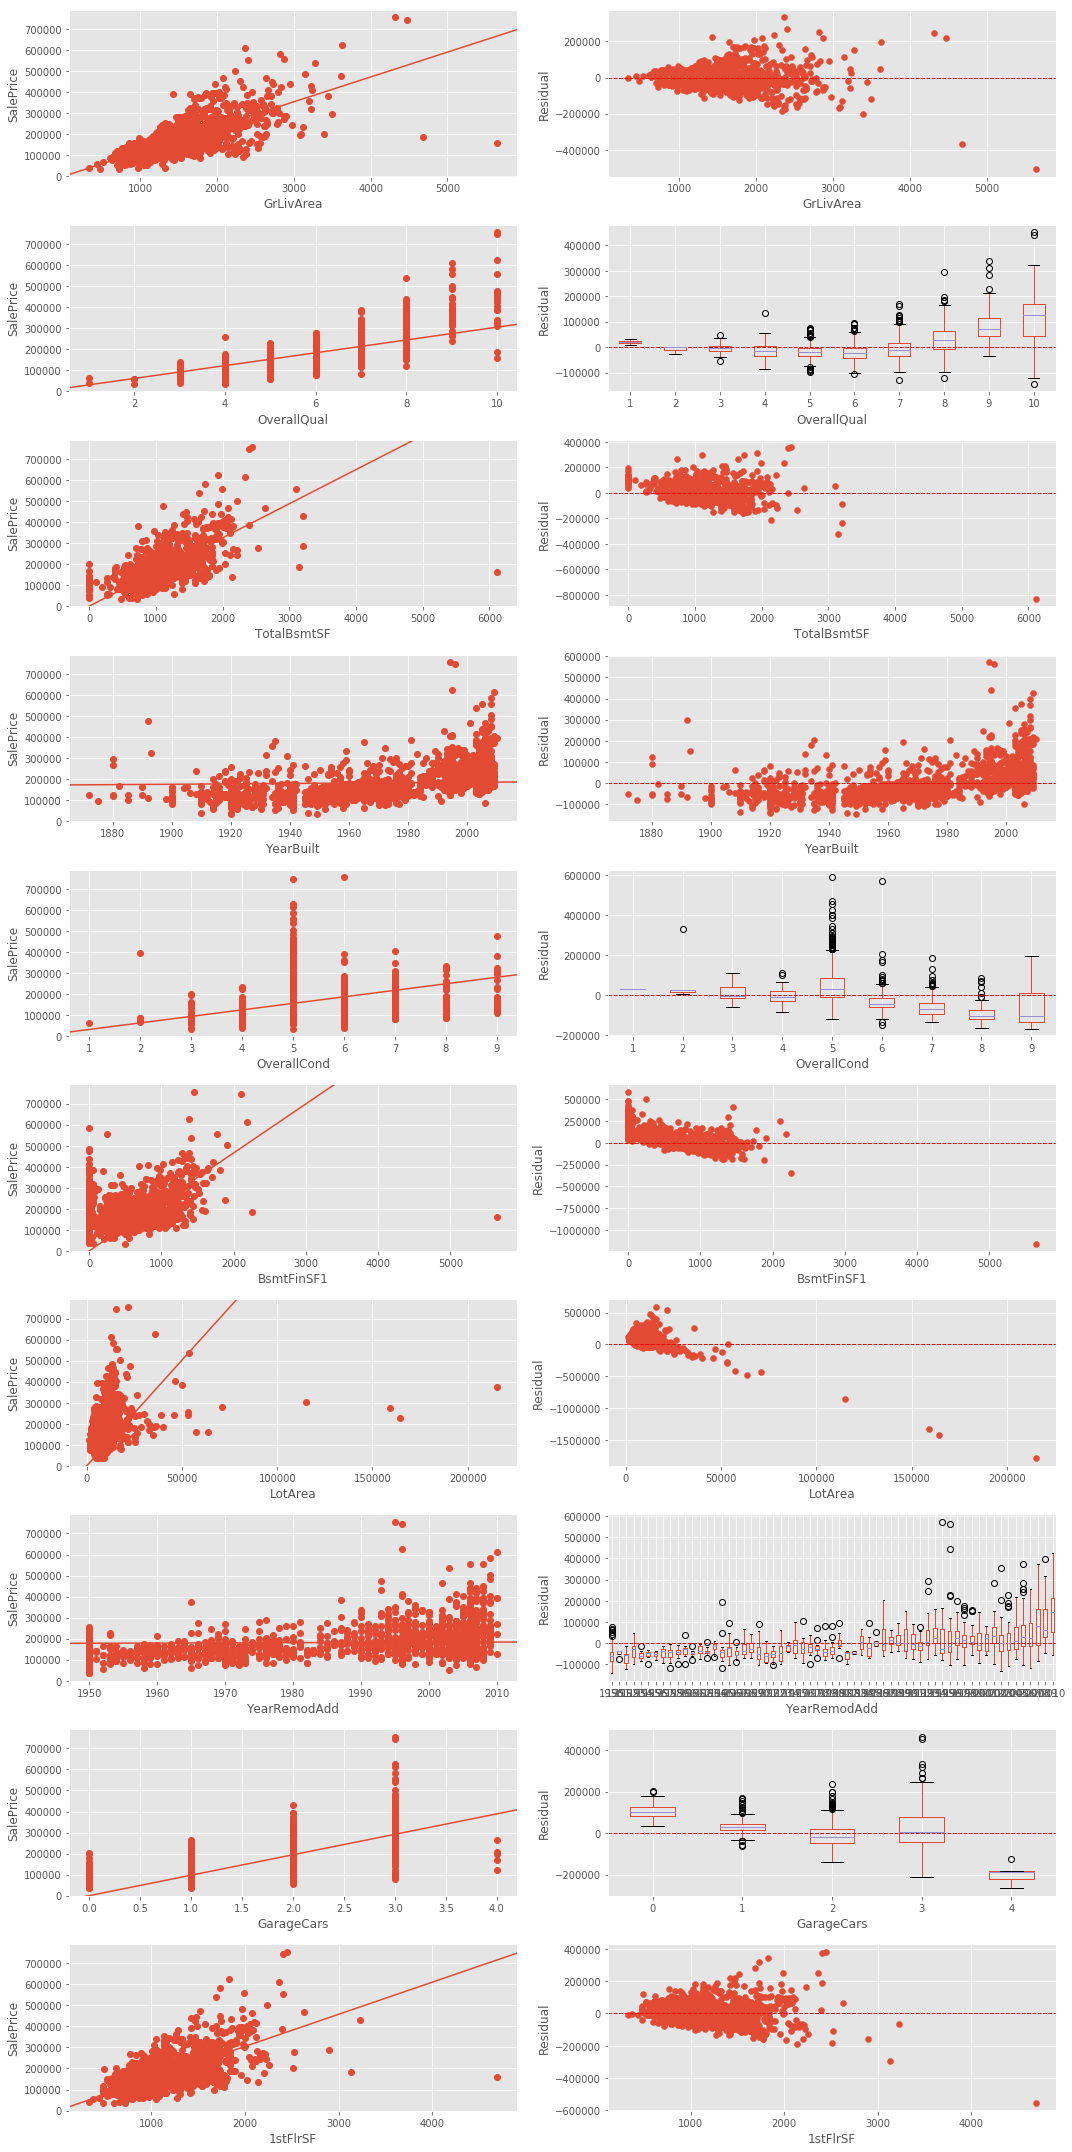

In [11]:
print('Univariate OLS plotted on 1) target, and 2) residual')
fig, axs = utils_ui.dynamic_subplots(df, top_features, project.target, 'residual', figsize=(15,30), cols=2)
fig.tight_layout()
plt.show()

## -- 3. Heteroskedasticity statistical tests --

Test Name | Description | Key Considerations
--- | --- | ---
Breusch-Pagan Test | Tests the null hypothesis of constant variance by refitting an auxiliary regression using the squared residual vs. the independent variables. If the auxiliary regression sum of squares (RSS) divided by two is above a certain threshold, the null hypothesis can be rejected. | The test statistic follows a chi-square distribution and the higher the value the more likely that heteroscedasticity exists. The test only detects linear forms of heteroscedasticity.
White Test | This is a special case of the Breusch- Pagan test in which auxiliary regression includes all the independent variables and their second order interaction terms (e.g., X1^2, X1*X2, X2*X3, etc.). | The N*R2 statistic follows a chi-square distribution and the higher the value the more likely that heteroscedasticity exists. The test captures nonlinear forms of heteroscedasticity. In case of a large number of independent variables relative to data, the White test can be difficult to interpret as the data may not be sufficiently large to offset the corresponding loss of degrees of freedom.

### Tests use statsmodels diagnostics and have the following output:
    Returns
    -------
    lm : float
        lagrange multiplier statistic
    lm_pvalue :float
        p-value of lagrange multiplier test
    fvalue : float
        f-statistic of the hypothesis that the error variance does not depend
        on x. This is an alternative test variant not the original LM test.
    f_pvalue : float
        p-value for the f-statistic

In [12]:
print('Breusch-Pagan Test:\n')
test = utils_stats.breusch_pagan_test(ols_model.resid, ols_model.model.exog)

Breusch-Pagan Test:

(Calculation: sigma_i = sigma * f(alpha_0 + alpha z_i))
Statistic                              Value
-----------------------------  -------------
Lagrange multiplier statistic  409.44
p-value                          9.20642e-82
f-value                         56.4727
f_pvalue                         2.03738e-96


In [13]:
print('White Test:\n')
test = utils_stats.het_white(ols_model.resid, ols_model.model.exog, retres = False)

White Test:

Statistic                                Value
-----------------------------  ---------------
Lagrange multiplier statistic  1291.28
p-value                           2.97188e-227
f-value                         164.133
f_pvalue                          0


# 4. Independence - Serial Correlation
Test Name | Description | Key Considerations
--- | --- | ---
Serial Residual Plot | Order the observations according to the relevant dimension (e.g., time, geography, etc.) and plot the corresponding residuals on the Y-axis. | Examine the plot for systematic patterns which may indicate a positive correlation of the error term across the driving dimension.
### This is a series line plot of the OLS model residual and a given time series.  
The example below shows a series of a feature in the model, YearBuilt, and a feature not in the OLS model, SaleDate.

Text(0,0.5,'Residual')

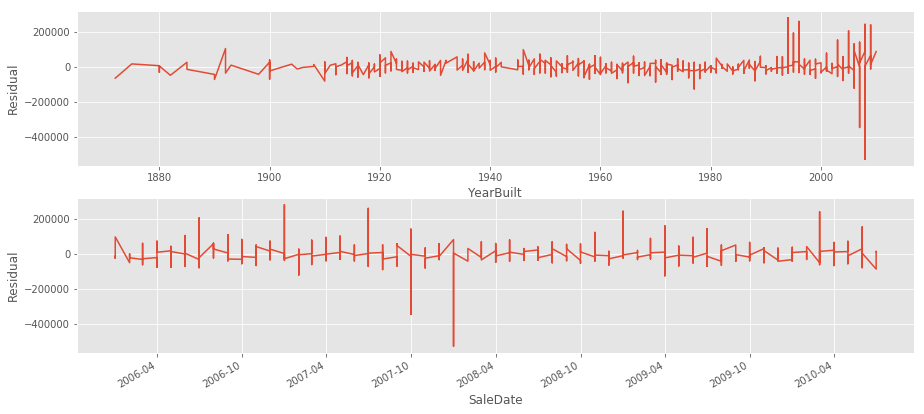

In [14]:
data = df.copy()

X = df[top_features]
y = df[project.target]
X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()

data['res'] = ols_model.resid

fig, axs = plt.subplots(2, 1, figsize=(15,7))

data.set_index('YearBuilt', inplace=True)
data.sort_index(inplace=True)
ax = data['res'].plot(ax=axs[0])
ax.set_ylabel("Residual")

data.set_index('SaleDate', inplace=True)
data.sort_index(inplace=True)
ax = data['res'].plot(ax=axs[1])
ax.set_ylabel("Residual")

## -- 4. Independence statistical tests --

Test Name | Description | Key Considerations
--- | --- | ---
Durbin Watson (DW) Test | Tests the null hypothesis that no serial correlation exists. The DW test statistic is calculated based on the residuals from the OLS regression. | The value of DW ranges from 0 to 4 with values close to 2 indicating no serial correlation. Positive serial correlation is associated with values lower than 2 and negative serial correlation is associated with values higher than 2. This test cannot be applied if the regression contains one or more lagged dependent variables, as the DW statistic will often be close to 2 even when the errors are serially correlated.

### This uses statsmodels durbin_watson with different sorting/indexing
statsmodels returns different values based on how the series is sorted or indexed

In [15]:
print('Durbin Watson:\n')
data = df.copy()
data['res'] = ols_model.resid
print(sms.durbin_watson(data.res))

data = df.copy()
data['res'] = ols_model.resid
data.set_index('SaleDate', inplace=True)
data.sort_index(inplace=True)
print(sms.durbin_watson(data.res))

data = df.copy()
data['res'] = ols_model.resid
data.set_index('YearBuilt', inplace=True)
data.sort_index(inplace=True)
print(sms.durbin_watson(data.res))

Durbin Watson:

1.976336905280618
2.048561950089046
2.075817988701457


# 5. Normality
Test Name | Description | Key Considerations
--- | --- | ---
Normal Probability Plot | Plot each residual against its expected value under normality. The expected values are calculated based on residual rank, error term standard deviation, and inverse standard normal distribution. A plot that is nearly linear suggests a normal error distribution. | Small sample sizes (e.g., <30) in general will make it hard to assess the nature of the probability distributions and, therefore, normality.
Histogram of Residuals | Perform a visual examination of a histogram of the residuals. An overlay of the normal distribution PDF with the same mean and standard deviation can assist with the comparison. |

### This uses statsmodels qqplot and scipy norm
The first qq plot assumes a norm distribution, adds fit=True to get standardized sample quantiles, and plots the 45 degree line.
The second is the histogram of the residuals.

Univariate QQ Plots


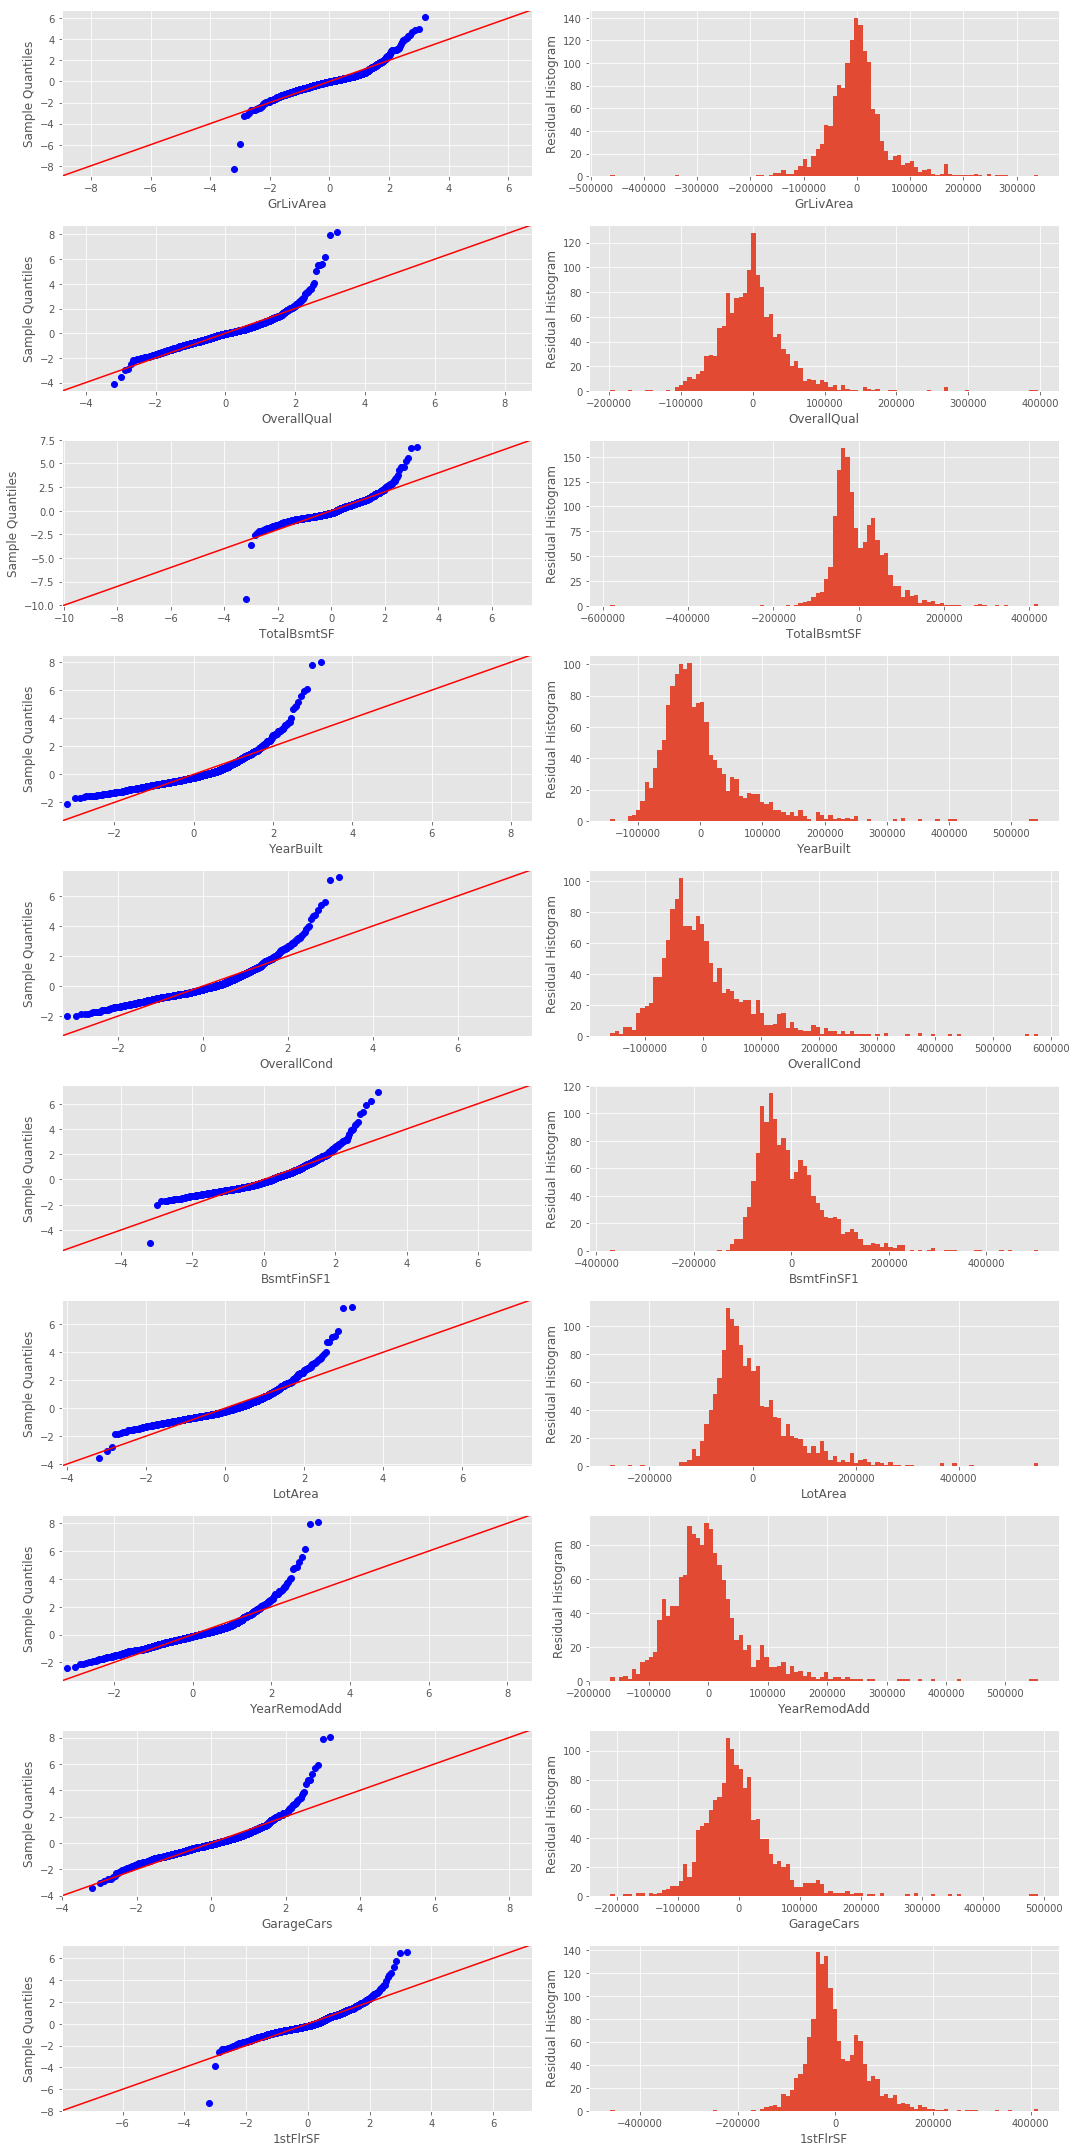

In [16]:
print('Univariate QQ Plots')
fig, axs = utils_ui.dynamic_subplots(df, top_features, project.target, 'residual_normality', figsize=(15,30), cols=2)
fig.tight_layout()
plt.show()

## -- 5. Normality statistical tests --

Test Name | Description | Key Considerations
--- | --- | ---
Shapiro-Wilk (SW) Test | Part of the "regression and correlation" class of tests, this test measures the ratio of the normally distributed weighted-least-squares estimates of scale obtained from order statistics and the population sample variance. | The power of the test can be low for small sample sizes.
Anderson-Darling (AD) Test | Falls under the empirical distribution function (EDF) category of tests and measures the weighted mean square distance between the target distribution and observed distribution. The weighted mean square distance is the test statistic. | Places greater emphasis on the tails of the distribution through the weighting scheme. Does not perform well with many ties / identical values. The power of the test can be low for small sample sizes.

In [17]:
print('Sharpio-Wilk (SW) test:')
stats.shapiro(df[top_features])

Sharpio-Wilk (SW) test:


(0.3426676392555237, 0.0)

### This uses scipy anderson and statsmodels normal_ad, but the results seem inconsistent...
statsmodels returns inf and nan for some features, scipy seems to have the same pvalue/critical values for all features.

In [18]:
print('Anderson-Darling (AD) Test:\n')
utils_stats.anderson_darling_test(df[top_features])
print()

one = 'OverallCond'
print('statsmodels:', sms.normal_ad(df[one]))
print('scipy:', stats.anderson(df[one]))
print()

for feat in feature_set:
    result = stats.anderson(df[feat])
    print(feat)
    print('- statistic: %s, pvalues at critical values:' % result.statistic)
    print('  ' + '    '.join(map(str, result.significance_level.tolist())))
    print('  ' + '  '.join(map(str, result.critical_values.tolist())))

Anderson-Darling (AD) Test:

Feature         Statistic          pvalue
------------  -----------  --------------
GrLivArea         14.5322    1.65933e-34
OverallQual       35.23      1.6005e-77
TotalBsmtSF      inf       nan
YearBuilt         30.9635    3.19392e-69
OverallCond      125.285     4.95981e-184
BsmtFinSF1       inf       nan
LotArea          inf       nan
YearRemodAdd      71.4944    3.47118e-136
GarageCars       122.132     1.61787e-182
1stFlrSF         inf       nan

statsmodels: (125.28514379301123, 0.0)
scipy: AndersonResult(statistic=125.285143793011, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

GrLivArea
- statistic: 14.532232080317272, pvalues at critical values:
  15.0    10.0    5.0    2.5    1.0
  0.574  0.654  0.785  0.916  1.089
OverallQual
- statistic: 35.230011585458215, pvalues at critical values:
  15.0    10.0    5.0    2.5    1.0
  0.574  0.654  0.785  0.916  1.089
TotalBsmtSF
- stat

# 6. Multicollinearity
Test Name | Description | Key Considerations
--- | --- | ---
Partial Regression Plot | For each independent variable, plot the following: • X-axis: residual from regressing the chosen independent variable against the other independent variables. • Y-axis: residual from regressing the dependent variable against the other independent variables (excluding the chosen variable). Overlay the scatter plot with a linear OLS best-fit line. | This is the analogous plot to an univariate scatter plot, but it is used for multiple regressions. It enables the validator to visualize the incremental contribution of a single variable to the model. The visual inspection should consider the quality of the linear scatter (e.g., Are the points well-spaced or clusters? Is there a clear correlation?) Not applicable to categorical independent variables.
Univariate Scatter Plot | For each independent variable, plot the following: • X-axis: the chosen independent variable. • Y-axis: dependent variable. | Enables the validator to view the contribution that a variable makes in the univariate case. The difference between the univariate and partial regression scatter plots indicates the degree of multicollinearity for that variable. Not applicable to categorical independent variables.

## Partial Regression Plots
### This uses statsmodels plot_partregress_grid
In a partial regression plot, to discern the relationship between the response variable and the  k -th variabe, we compute the residuals by regressing the response variable versus the independent variables excluding  Xk . We can denote this by X∼k . We then compute the residuals by regressing  Xk  on  X∼k . The partial regression plot is the plot of the former versus the latter residuals.  This is helpful to discern the effects of the individual data values on the estimation of a coefficient (helpful for outlier detection).

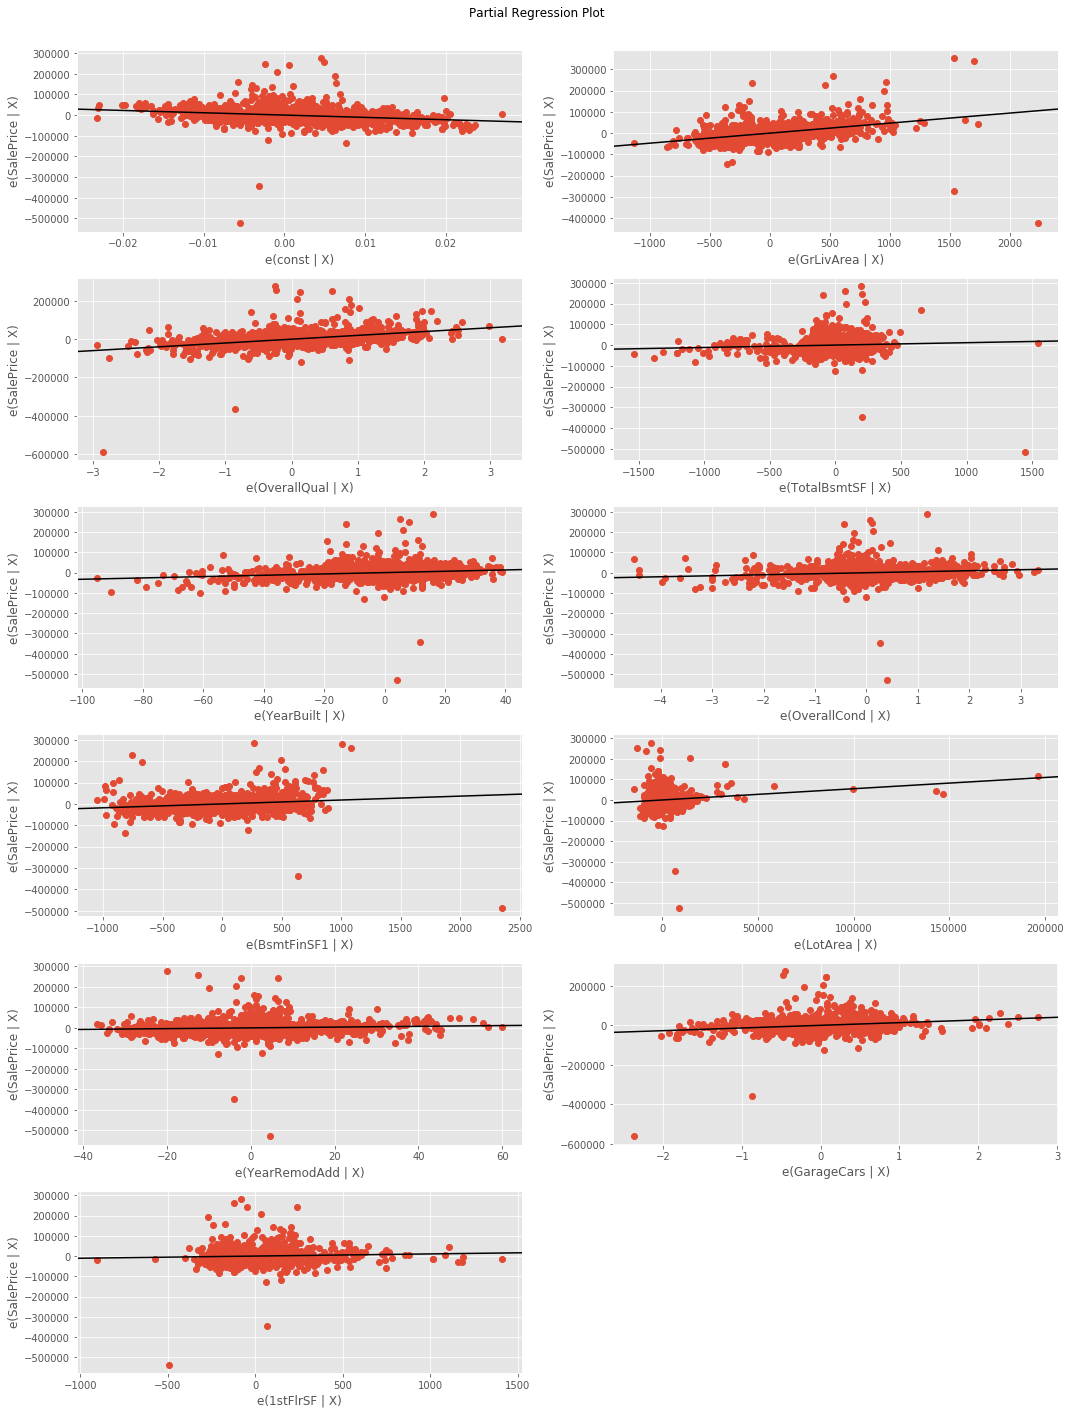

In [19]:
fig = plt.figure(figsize=(15,20))
fig = sm.graphics.plot_partregress_grid(ols_model, fig=fig)

Univariate Scatter Plots for Continuous Independent Variables:


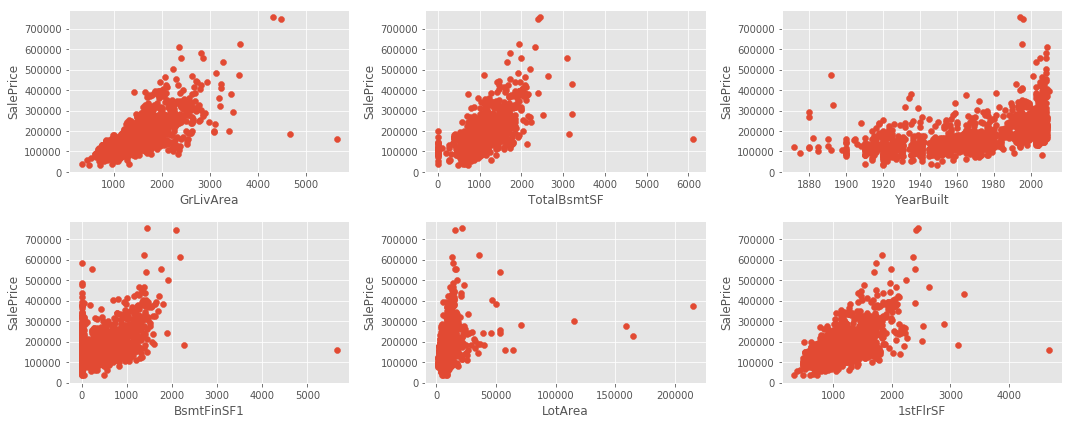

In [20]:
print('Univariate Scatter Plots for Continuous Independent Variables:')
fig, axs = utils_ui.dynamic_subplots(df, likely_cont, project.target, 'scatter', figsize=(15,6))
fig.tight_layout()
plt.show()

## -- 6. Multicollinearity statistical tests --

Test Name | Description | Key Considerations
--- | --- | ---
Correlation Test | Calculate the correlation matrix of all the independent variables. Apply a heat map if there are many variables, to facilitate visual identifications of the high/low correlations. High absolute correlation values indicate that multicollinearity could be a problem. | Calculate the correlation matrix of all the independent variables. Apply a heat map if there are many variables, to facilitate visual identifications of the high/low correlations. High absolute correlation values indicate that multicollinearity could be a problem.
Condition Index | Represents the collinearity of the combination of variables in the dataset. | The largest condition index is the condition number. A large condition number indicates that the regression estimates may have considerable errors due to multicollinearity. As a single indicator, the condition number gives an overall assessment of mulicollinearity in the model. Individual variables can be assessed by VIF. (see below) Generally, Condition Indexes greater than 30 would be a cause of particular concern and should therefore be evaluated carefully taking into account the model context and other test results.
Variance Inflation Factors (VIF) Test | Calculate and report the VIF for all independent variables. | Based on VIF value compared to selected threshold, determine if further inspection of multicollinearity is warranted. For categorical variables VIF can be defined by using the partial generalized R2 that is obtained from fitting a multinomial logistic model on other variables. Generally, VIFs greater than 5 would be a cause of particular concern and should therefore be evaluated carefully taking into account the model context and other test results.
VIF Drop-Out test | Individually assess the drop-out of each high VIF variable from the final model by comparing regression statistics (e.g., Adjusted R2) before and after inclusion. | The comparison of regression statistics with and without high VIF variables can sometimes be more useful if performed on a weighted or segmented basis, since the same independent variables can be correlated for some parts of the portfolio but uncorrelated and useful for other parts.

Correlation Test:


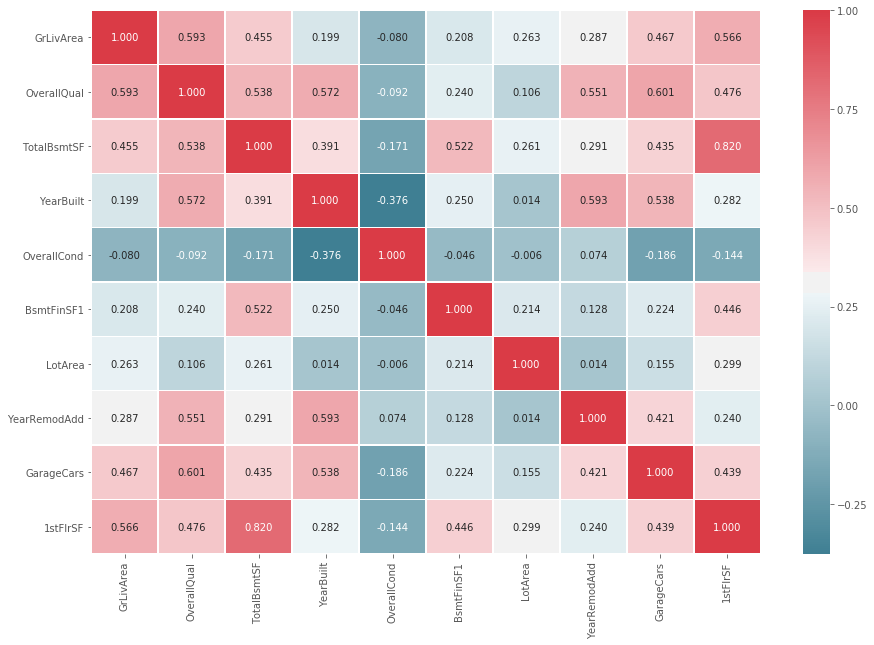

In [21]:
print('Correlation Test:')
correlation = df[top_features].corr()
fig, ax = plt.subplots(1, figsize=(15,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, annot=True, fmt='.3f', linewidths=.5, cmap=cmap, ax=ax)

In [22]:
print('Condition number:')
utils_stats.multicollinearity_condition_number(df[top_features])

Condition number:


5895.79314619806

In [23]:
print('Variance Inflation Factor (VIF):\n')
utils_stats.VIF_test(df, project.target, top_features)

Variance Inflation Factor (VIF):

Feature           VIF    Dropout R2
------------  -------  ------------
GrLivArea     2.12455      0.744352
OverallQual   2.82336      0.747858
TotalBsmtSF   3.84396      0.789219
YearBuilt     2.84903      0.784815
OverallCond   1.44771      0.786947
BsmtFinSF1    1.43372      0.782653
LotArea       1.15215      0.786184
YearRemodAdd  2.02807      0.789109
GarageCars    1.87547      0.781641
1stFlrSF      3.69337      0.789546
(OLS R2 with no dropout: 0.7902777372479277)
